# **Week5 Part2: Object Loacalization**

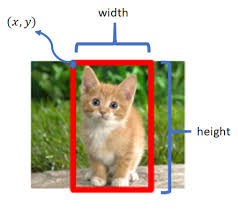

In [23]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
# Mount file from your drive


# **Read XML for Bounding Box Only**

Parse a Pascal VOC XML file and extract     normalized bounding box coordinates.

**Function parameter**:
        xml_path (str): Path to the XML annotation file.

**Returns**:
list: Normalized bounding box [xmin, ymin, xmax, ymax]
with values in range [0, 1].


In [2]:
def parse_xml(xml_path):

    # Load and parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Read image size : width height
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    # One oject per image
    # Read bounding box
    box = root.find('object').find('bndbox')
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
    # Nomalize coordinates to 0 - 10
    return [
        xmin / w,
        ymin / h,
        xmax / w,
        ymax / h
    ]

# **Load images and bounding box annotations**

**Parameters**:
        image_dir (str): Directory containing training image files.
        xml_dir (str): Directory containing Pascal VOC XML annotation files.
        img_size (int):  For resizing.

**Returns**:
tuple: [xmin, ymin, xmax, ymax]

In [3]:
def load_dataset(image_dir, xml_dir, img_size=224):
    # Create images and bboxes lists
    images, boxes = [], []

    # Loop through all image files in the directory
    for f in os.listdir(image_dir):
        if f.endswith(".jpg"):

            # Contruct full part for image and XML annotaiton
            img_path = os.path.join(image_dir, f)
            # Read image using cv2
            img = cv2.imread(img_path)
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize image using img_size parameter
            img = cv2.resize(img, (img_size, img_size))
            # Normalize pixel value to range 0-1
            img = img / 255.0

            # Parse bounding box from XML
            xml_part = os.path.join(xml_dir, f.replace(".jpg", ".xml"))
            box = parse_xml(xml_part)

            # Add image and bbox to list
            images.append(img)
            boxes.append(box)
    # Return image and bbox
    return np.array(images), np.array(boxes)

# **Creating the Model for Object Localization : BBbox Only**

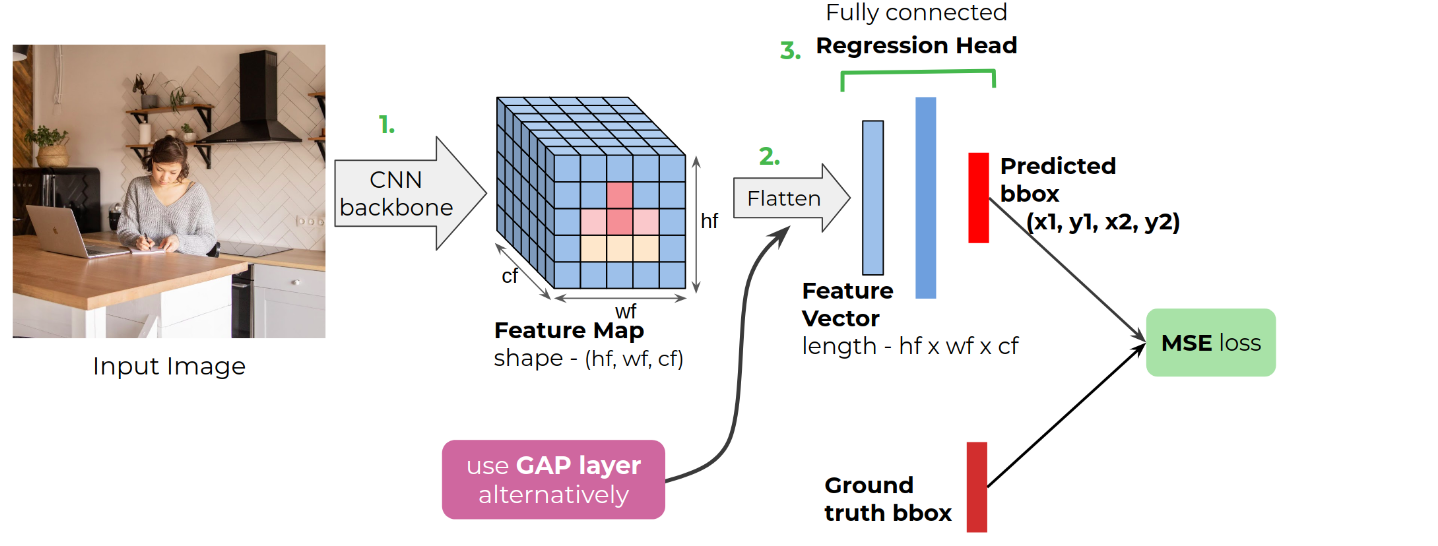

In [12]:
def build_cnn():

    """
    Custom CNN for object localization.
    Output: Bounding box: xmin, ymin, xmax, ymax
    """
    # Input layer
    inputs = layers.Input(shape=(224, 224, 3))

    # Feature extractor: Convolutional layers
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPool2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)

    # Regression head: Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(4, activation='sigmoid')(x)

    # Return model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# **Load the training dataset**

1.   X : Input images
2.   y: Bounding box label -> xmin ymin ...


In [9]:
X, y = load_dataset(
    image_dir=r"C:\Users\jinny\Desktop\cv\blood dataset\train",
    xml_dir=r"C:\Users\jinny\Desktop\cv\blood dataset\train"
)

In [10]:
y[:5]

array([[0.27717391, 0.27567568, 0.7173913 , 0.74054054],
       [0.2798913 , 0.27567568, 0.73097826, 0.72972973],
       [0.26358696, 0.27567568, 0.72826087, 0.72432432],
       [0.2798913 , 0.27837838, 0.74456522, 0.72432432],
       [0.27445652, 0.25945946, 0.74456522, 0.73783784]])

# **Compile and Train**
- Adma opimizer
- MSE loss
- MAE matrices


In [13]:
# Build model
models = build_cnn()
models.summary()
# Compile
models.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse'
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

In [14]:
# Train model with 50 epochs 4 images in each batch  and split dataset to validation
models.fit(
    X, y,
    epochs=50,
    batch_size=4,
    validation_split=0.1
)

Epoch 1/50
7/7 [==============================] - 14s 268ms/step - loss: 0.0204 - val_loss: 0.0095
Epoch 2/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 3/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 4/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/50
7/7 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11/50
7/7 [==========

# **Predict the Bounding Box + Class label**

In [15]:
IMG_SIZE = 224

# Preprocess the unseen image
def preprocess_image(img_path):
    # Read image
    img = cv2.imread(img_path)
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Keep the actual image size
    w, h, _ = img_rgb.shape
    #Resize image to match model input
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    # Nomalize image pixes value [0,1]
    img_normalized = img_resized / 255.0
    # Return image rgb, image norm and (h w)
    return img_rgb, img_normalized, (h, w)

In [20]:
# Test image part
test_image_path = r"C:\Users\jinny\Desktop\cv\blood dataset\test\112700824J_010.jpg"
#Preprocess test image from your drive
img_org, img_input, (w,h) = preprocess_image(test_image_path)
# Predict boundingbox and class label
pred = models(img_input[np.newaxis, ...])[0]

tf.Tensor([0.30836612 0.26503727 0.7318683  0.7197496 ], shape=(4,), dtype=float32)


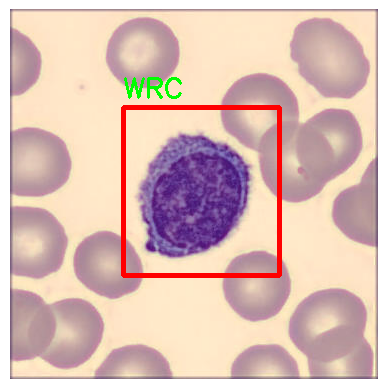

In [28]:
# Bounding box (normalized → pixel)
print(pred)
xmin = int(pred[0] * w)
ymin = int(pred[1] * h)
xmax = int(pred[2] * w)
ymax = int(pred[3] * h)
# Draw rectangle from predict bbox
cv2.rectangle(
    img_org,
    (xmin, ymin),
    (xmax, ymax),
    (255, 0, 0),
    3
)
# Put the class name on the bbox
cv2.putText(
    img_org,
    "WRC",
    (xmin, ymin - 10),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.9,
    (0, 255, 0),
    2
)
plt.imshow(img_org)
plt.axis('off')
plt.show()

# Thank you